In [2]:
%matplotlib inline

import matplotlib
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups

In [3]:
comp_categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
comp_train = fetch_20newsgroups(subset='train', categories=comp_categories, shuffle=True, random_state=42)
rec_train = fetch_20newsgroups(subset='train', categories=rec_categories, shuffle=True, random_state=42)
comp_test = fetch_20newsgroups(subset='test', categories=comp_categories, shuffle=True, random_state=42)
rec_test = fetch_20newsgroups(subset='test', categories=rec_categories, shuffle=True, random_state=42)

#all_points = fetch_20newsgroups(subset='all', categories=comp_categories+rec_categories, shuffle=True, random_state=42)



In [4]:
# 1. transform the documents into TF-IDF vectors. 
# Use min df = 3, exclude the stopwords (no need to do stemming). Report the dimensions of the TF-IDF matrix you get.
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(min_df=3, stop_words=text.ENGLISH_STOP_WORDS) 
vectorized_corpus = vectorizer.fit_transform(comp_train.data + rec_train.data)

tfidf_transformer = TfidfTransformer()
trainX = tfidf_transformer.fit_transform(vectorized_corpus)

testX = tfidf_transformer.transform(vectorizer.transform(comp_test.data + rec_test.data))

# 0 for comp class, 1 for rec class
trainy = np.zeros(shape=(len(comp_train.filenames) + len(rec_train.filenames),))
trainy[len(comp_train.filenames):] = 1

testy = np.zeros(shape=(len(comp_test.filenames) + len(rec_test.filenames),))
testy[len(comp_test.filenames):] = 1

In [5]:
print trainX.shape, testX.shape, trainy.shape, testy.shape

(4732, 20297) (3150, 20297) (4732,) (3150,)


In [6]:
# 2. Apply K-means clustering with k = 2 using the TF-IDF data.
# Compare the clustering results with the known class labels.
# a) Inspect the contingency matrix to get a sense of your clustering result.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.cluster import contingency_matrix

km = KMeans(n_clusters=2, init='k-means++', max_iter=100)
km.fit(trainX)
ypred = km.predict(testX)

In [7]:
print km.labels_.shape, testy.shape
contingency_matrix(testy, ypred, eps=None, sparse=False)

(4732,) (3150,)


array([[1558,    2],
       [ 925,  665]])

In [8]:
# b) 5 Metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(testy, ypred))
print("Completeness: %0.3f" % metrics.completeness_score(testy, ypred))
print("V-measure: %0.3f" % metrics.v_measure_score(testy, ypred))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(testy, ypred))
print("Adjusted Mutual Info: %0.3f" % metrics.adjusted_mutual_info_score(testy, ypred))

Homogeneity: 0.243
Completeness: 0.326
V-measure: 0.278
Adjusted Rand-Index: 0.169
Adjusted Mutual Info: 0.243


In [9]:
# 3. a) Report the plot of the percent of variance the top r principle components can retain v.s. r, for r = 1 to 1000.
from scipy.sparse.linalg import svds

#Use SVD to find 1000 principal components
u, singular_values, vt = svds(trainX, k=1000)
print(len(singular_values))


1000


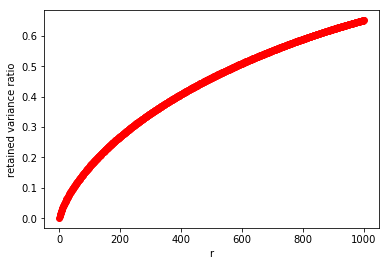

In [14]:
from sklearn.decomposition import TruncatedSVD, NMF

rs = np.arange(1, 1001)

svd = TruncatedSVD(n_components=1000)
svd.fit(trainX)
explained_vars = svd.explained_variance_ratio_

variances = np.zeros(explained_vars.shape)
variances[0] = explained_vars[0]
for i in range(1,1000):
    variances[i] = explained_vars[i] + variances[i-1]
    
plt.plot(rs, variances, 'ro')
plt.xlabel('r')
plt.ylabel('retained variance ratio')

In [15]:
from sklearn.decomposition import TruncatedSVD, NMF

def get_scores(y, yhat):
    cont_matrix = contingency_matrix(y,yhat)# ypred)

    homogeneity = metrics.homogeneity_score(y, yhat)
    completeness_score = metrics.completeness_score(y, yhat)
    v_measure_score = metrics.v_measure_score(y, yhat)
    adjusted_rand_score = metrics.adjusted_rand_score(y, yhat)
    adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(y, yhat)
    return cont_matrix, homogeneity, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
   
    
def get_svd_scores(num_components):
    svd = TruncatedSVD(n_components=num_components)
    train_lsi = svd.fit_transform(trainX)
    test_lsi = svd.transform(testX)

    km = KMeans(n_clusters=2)
    km.fit(train_lsi)

    ypred = km.predict(test_lsi)
    return get_scores(testy, ypred)

    
def get_nmf_scores(num_components):
    nmf = NMF(n_components=num_components)
    train_nmf = nmf.fit_transform(trainX)
    test_nmf = nmf.transform(testX)
    
    km = KMeans(n_clusters=2)
    km.fit(train_nmf)
    ypred = km.predict(test_nmf)
    
    return get_scores(testy, ypred)
    

Text(0,0.5,u'singular val')

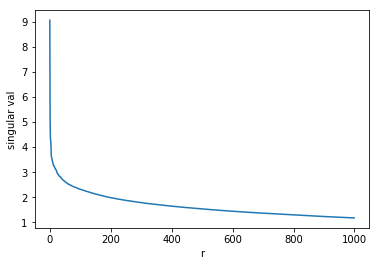

In [113]:
#print(sorted(singular_values, reverse=True))
sorted_singular_vals = sorted(singular_values, reverse=True)
plt.plot(sorted_singular_vals)
plt.xlabel('r')
plt.ylabel('singular val')

LSI...
('contingency matrix for r=', 1)
[[769 791]
 [846 744]]
('contingency matrix for r=', 2)
[[  46 1514]
 [1161  429]]
('contingency matrix for r=', 3)
[[1557    3]
 [ 848  742]]
('contingency matrix for r=', 5)
[[1558    2]
 [ 989  601]]
('contingency matrix for r=', 10)
[[   2 1558]
 [ 632  958]]
('contingency matrix for r=', 20)
[[   1 1559]
 [ 634  956]]
('contingency matrix for r=', 50)
[[1559    1]
 [ 960  630]]
('contingency matrix for r=', 100)
[[ 106 1454]
 [1552   38]]
('contingency matrix for r=', 300)
[[1558    2]
 [ 930  660]]
r: 1 
 homogeneity=0.00111 
 completeness=0.00111 
 v-measure=0.00111 
 adj rand index=0.00123 
 adj mutual info=0.00088 
---
r: 2 
 homogeneity=0.44069 
 completeness=0.45890 
 v-measure=0.44961 
 adj rand index=0.48762 
 adj mutual info=0.44056 
---
r: 3 
 homogeneity=0.27609 
 completeness=0.34983 
 v-measure=0.30862 
 adj rand index=0.21111 
 adj mutual info=0.27593 
---
r: 5 
 homogeneity=0.21459 
 completeness=0.30460 
 v-measure=0.25179 
 

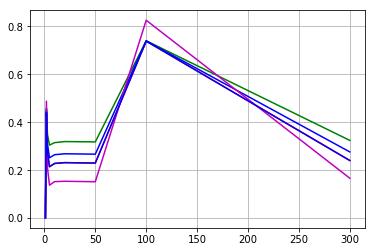

In [18]:
# b) LSI vs. NMF
# Specifically, try r = 1, 2, 3, 5, 10, 20, 50, 100, 300, and plot the 5 
# measure scores v.s. r for both SVD and NMF; also report the contingency matrices for each r.
# Report the best r choice for SVD and NMF respectively.
# How do you explain the non-monotonic behavior of the measures as r increases?

r_vals = [1,2,3,5,10,20,50,100,300]
contingency_matrices = []
h_vals = []
c_vals = []
v_vals = []
rand_vals = []
mutual_vals = []
print("LSI...")
for r in r_vals:
    contin, h, c, v, rand, mutual = get_svd_scores(num_components=r)
#    contingency_matrices.append(contin)
    print("contingency matrix for r=", r)
#    print(h, c, v, rand, mutual)
    print(contin)
    h_vals.append(h)
    c_vals.append(c)
    v_vals.append(v)
    rand_vals.append(rand)
    mutual_vals.append(mutual)
    
    
start_index = 0    
r_vals = r_vals[start_index:]
h_vals = h_vals[start_index:]
c_vals = c_vals[start_index:]
v_vals = v_vals[start_index:]
rand_vals = rand_vals[start_index:]
mutual_vals = mutual_vals[start_index:]

for r, h, c, v, rand, mutual in zip(r_vals, h_vals, c_vals, v_vals, rand_vals, mutual_vals):
    print("r: %i \n homogeneity=%.5f \n completeness=%.5f \n v-measure=%.5f \n adj rand index=%.5f \n adj mutual info=%.5f \n---" % (r, h, c, v, rand, mutual))

# print(h_vals)
# print(c_vals)
# print(v_vals)
# print(rand_vals)
# print(mutual_vals)

res_list = [np.argmax(h_vals), np.argmax(c_vals), np.argmax(v_vals), np.argmax(rand_vals), np.argmax(mutual_vals)]
print(res_list)
# best_index = int(np.mean(res_list)) # not sure if this works e.g. [0,1,0,3,2,0]
best_index = np.bincount(res_list).argmax() # most frequent index
print(best_index)
    
print("Best r-value is: ", r_vals[best_index])
plt.plot(r_vals, h_vals, 'r', label="homogenity")
plt.plot(r_vals, c_vals, 'g', label="completeness score")
plt.plot(r_vals, v_vals, 'b', label="v measure")
plt.plot(r_vals, rand_vals, 'm', label="rand index")
plt.plot(r_vals, mutual_vals, 'b', label="adjusted mutual information")
plt.grid()
    
    



NMF...
('contingency matrix for r=', 1)
[[791 769]
 [744 846]]
('contingency matrix for r=', 2)
[[ 139 1421]
 [1478  112]]
('contingency matrix for r=', 3)
[[1558    2]
 [ 969  621]]
('contingency matrix for r=', 5)
[[1558    2]
 [1102  488]]
('contingency matrix for r=', 10)
[[1558    2]
 [1089  501]]
('contingency matrix for r=', 20)
[[1549   11]
 [1573   17]]
('contingency matrix for r=', 50)
[[1524   36]
 [1590    0]]
('contingency matrix for r=', 100)
[[1560    0]
 [1576   14]]
('contingency matrix for r=', 300)
[[1496   64]
 [1589    1]]
r: 1 
 homogeneity=0.00111 
 completeness=0.00111 
 v-measure=0.00111 
 adj rand index=0.00123 
 adj mutual info=0.00088 
---
r: 2 
 homogeneity=0.59932 
 completeness=0.59959 
 v-measure=0.59946 
 adj rand index=0.70657 
 adj mutual info=0.59923 
---
r: 3 
 homogeneity=0.22328 
 completeness=0.31119 
 v-measure=0.26001 
 adj rand index=0.14687 
 adj mutual info=0.22310 
---
r: 5 
 homogeneity=0.16754 
 completeness=0.26866 
 v-measure=0.20638 
 

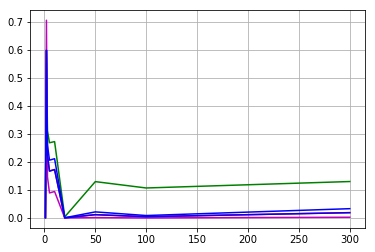

In [19]:
print("NMF...")   
contingency_matrices = []
h_vals = []
c_vals = []
v_vals = []
rand_vals = []
mutual_vals = []
for r in r_vals:
    contin, h, c, v, rand, mutual = get_nmf_scores(num_components=r)
    print("contingency matrix for r=", r)
    print(contin)
    h_vals.append(h)
    c_vals.append(c)
    v_vals.append(v)
    rand_vals.append(rand)
    mutual_vals.append(mutual)
    
    
start_index = 0    
r_vals = r_vals[start_index:]
h_vals = h_vals[start_index:]
c_vals = c_vals[start_index:]
v_vals = v_vals[start_index:]
rand_vals = rand_vals[start_index:]
mutual_vals = mutual_vals[start_index:]

# print(h_vals)
# print(c_vals)
# print(v_vals)
# print(rand_vals)
# print(mutual_vals)

for r, h, c, v, rand, mutual in zip(r_vals, h_vals, c_vals, v_vals, rand_vals, mutual_vals):
    print("r: %i \n homogeneity=%.5f \n completeness=%.5f \n v-measure=%.5f \n adj rand index=%.5f \n adj mutual info=%.5f \n---" % (r, h, c, v, rand, mutual))


res_list = [np.argmax(h_vals), np.argmax(c_vals), np.argmax(v_vals), np.argmax(rand_vals), np.argmax(mutual_vals)]
print(res_list)
# best_index = int(np.mean(res_list))
best_index = np.bincount(res_list).argmax() # most frequent index
print(best_index)
    
print("Best r-value is: ", r_vals[best_index])
plt.plot(r_vals, h_vals, 'r', label="homogenity")
plt.plot(r_vals, c_vals, 'g', label="completeness score")
plt.plot(r_vals, v_vals, 'b', label="v measure")
plt.plot(r_vals, rand_vals, 'm', label="rand index")
plt.plot(r_vals, mutual_vals, 'b', label="adjusted mutual information")
plt.grid()




In [ ]:
# How do you explain the non-monotonic behavior of the measures as r increases?
# If the number of dimensions, r, get too high, the euclidiean distances between most examples are reduced to the same 
# and therefore, becomes no longer a discerning metric. This explains the sharp decrease in cluster metrics as r increases.